# Audio resampling in Python

*by Joachim Thiemann, 11.8.2016, joachim.thiemann@uni-oldenburg.de*

Added by Jonas Haag in 2020:

- torchaudio
- lilfilter
- julius

One of the most basic tasks in audio processing anyone would need to do is resampling audio files; seems like the data you want to process is _never_ sampled in the rate you want.  44.1k? 16k? 8k? Those are the common ones; there are some really odd ones out there.

Resampling is actually quite hard to get right.  You need to properly choose your antialias filters, and write a interpolation/decimation procedure that won't introduce too much noise.  There have been books written on this topic.  For the most part, there is no single univeral way to to this right, since context matters.

For a more detailed discussion on sample rate conversion see the aptly named "Digital Audio Resampling Homepage" [https://ccrma.stanford.edu/~jos/resample/].  Then look at [http://src.infinitewave.ca/] for a super informative comparison of a ton of resampling implementations.  _No seriously, go there._  (It inspired me to compare the methods below using a sine sweep.)

MATLAB has the built-in `resample` function.  Everyone uses it.  It works, but also sucks in many aspects - a much better function is in the DSP toolbox, but as near as I can tell, noone uses it (even when copious other parts of the DSP toolbox are being used!)

But I'm not talking about MATLAB, I'm talking about Python here, and it doesn't have a default resampling method - except if you're doing any kind of numerical computing, you'll be using `numpy` and probably `scipy` --- and the latter _has_ a built-in resample function.

To get ahead of myself a bit, `scipy.signal.resample` *sucks* _for audio resampling_.  That becomes apparent quite quickly - it works in frequency domain, by basically truncation or zero-padding the signal in the frequency domain.  This is quite ugly in time domain (especially since it assumes the signal to be _circular_).

There are two alternatives I want to point at that are "turn-key", that is, you just have to specify your resampling ratio, and the library does the rest.  I know of a few others, but at the time of writing this they didn't seem as easy to use (eg. just doing the interpolation/decimation, but not calculating a filter.)  If there are other notable libraries I should know of, please mention it in the comments of the blog version of this notebook [http://signalsprocessed.blogspot.com/2016/08/audio-resampling-in-python.html].

The first alternative is `scikit.resample`.  Using it has two problems: it relies on an external (C-language) library called "Secret Rabbit Code" (SRC as in "sample rate conversion", geddit?) aka libsamplerate.  Not a problem in itself, but you need to install it and this step is not automated in pip and friends (as far as I know at time of writing).  (Problem for me was that I needed to run it on a platform where I couldn't do this easily.)  Problem 2: scikit.resample 0.3.3 is Python 2 only, and the Python 3 version is unofficial (0.4.0-dev, I used [https://github.com/gregorias/samplerate]).

The other one is `resampy`, which can be found in PyPI or [https://github.com/bmcfee/resampy].  It is easy to install and works with Python 3 (`librosa` now uses it as preferred resampler over libsamplerate)

TL;DR: if you can install external libs, use scikit.resample (0.4.0-dev). `resampy` is faster, but not as good, but entirely reasonable.  (If MATLAB `resample` is good enough for you, `resampy` will serve you just fine and is easier to install)

Now for a comparison with pretty pictures.

In [1]:
!apt-get -qq install -y libsamplerate0-dev
!pip -q install samplerate scipy resampy torchaudio julius
!pip -q install git+https://github.com/gregorias/samplerate.git
!pip install git+https://github.com/danpovey/filtering.git

  Cloning https://github.com/danpovey/filtering.git to /tmp/pip-req-build-w77qrkds
  Running command git clone -q https://github.com/danpovey/filtering.git /tmp/pip-req-build-w77qrkds
  Created wheel for lilfilter: filename=lilfilter-0.0.1-cp37-none-any.whl size=72722 sha256=03ef93c271bfa4911c3dd337f08e3cbd3743a4170c262821f6cc29e704efe385
  Stored in directory: /tmp/pip-ephem-wheel-cache-u6ihjggg/wheels/8b/b1/f8/b7106b99c253f1274cb19ec744d4ecf1e79b2453ec8be97364
Successfully built lilfilter


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import samplerate  # https://pypi.org/project/samplerate/
import scikits.samplerate  # https://github.com/gregorias/samplerate
import scipy.signal
import resampy
import torch, torchaudio
import lilfilter  # https://github.com/danpovey/filtering
import julius  # https://github.com/adefossez/julius

In [3]:
!pip freeze | grep -E "samplerate|scipy|resampy|torchaudio|lilfilter|julius|scikits"

julius==0.2.3
lilfilter==0.0.1
resampy==0.2.2
samplerate==0.1.0
scikits.samplerate==0.4.0.dev0
scipy==1.4.1
torchaudio==0.8.1


## Downsampling a sweep

A common task is to convert between the CD sampling rate of 44.1 kHz, and the multiples of 8kHz that originated from the telekon industry.  In particular, 48kHz.  (Supposedly the rate of 44.1k was chosen in part _because_ is was difficult to convert to 48 kHz; but it is also connected to NTSC timing).  So let's have a sweep sampled at 48 kHz.

In [4]:
VMIN = -150

P = 48000
Q = 44100

offset = 2000
instfreq = np.exp(np.linspace(np.log(offset+100), np.log(offset+23900), 96000))-offset
deltaphase = 2*np.pi*instfreq/P
cphase = np.cumsum(deltaphase)
sig = np.sin(cphase, dtype=np.float64)

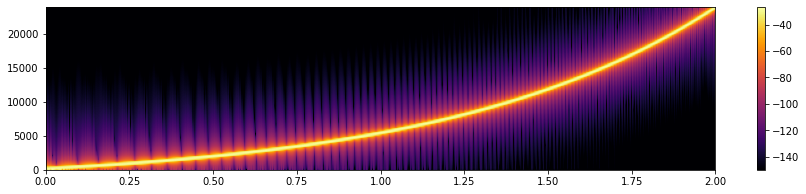

In [5]:
plt.figure(figsize=(15,3))
plt.specgram(sig, scale='dB', Fs=P, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,P/2))

Now convert it to 44.1 kHz using the different libraries, and plot the spectrograms.

### samplerate

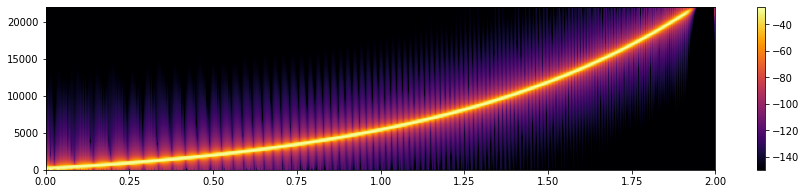

In [6]:
plt.figure(figsize=(15,3))
plt.specgram(samplerate.resample(sig, Q/P, 'sinc_best'),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

`scikit.samplerate` (or `libsamplerate` AKA "Secret Rabbit Code") does it well. Almost no aliasing, yet close to Nyquist, and noise levels in line with the input.  Note that once the sweep is above Nyquist, the output is basically nil.

### scikits-samplerate

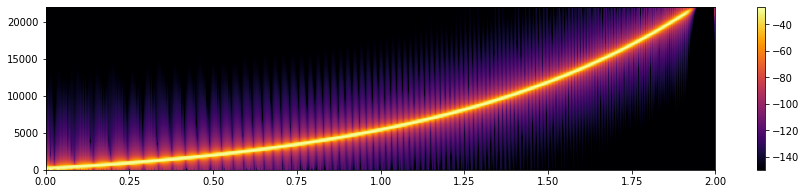

In [7]:
plt.figure(figsize=(15,3))
plt.specgram(scikits.samplerate.resample(sig, Q/P, 'sinc_best'),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### scipy.signal.resample

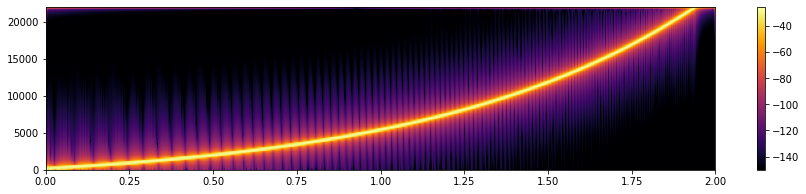

In [8]:
plt.figure(figsize=(15,3))
plt.specgram(scipy.signal.resample(sig, int(len(sig)*Q/P)),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

And this is `scipy.signal.resample`.  Throughout the entire signal there is a high-frequency tone, and there is considerable energy even if the sweep is above Nyquist.  This is a result of the frequency-domain processing operating on the entire signal at one.  This is NOT suited to audio signals.

`torchaudio.transforms.Resample`

### resampy (librosa)

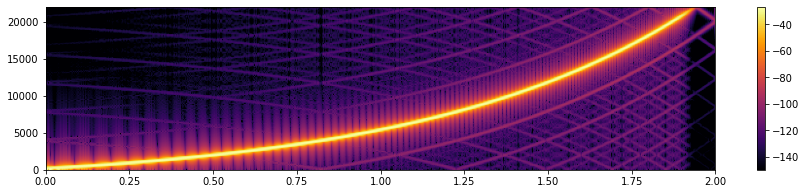

In [9]:
plt.figure(figsize=(15,3))
plt.specgram(resampy.resample(sig, P, Q, filter="kaiser_best"),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

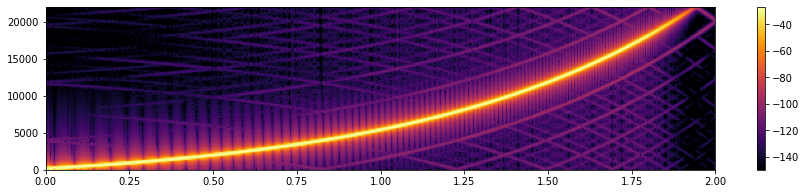

In [10]:
plt.figure(figsize=(15,3))
plt.specgram(resampy.resample(sig, P, Q, filter="kaiser_fast"),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

Finally, `resampy`.  There are some funny nonlinear effects, but at very low level - for audio applications generally nothing to worry about.  Even the aliasing is below -60 dB.  So, while not as good as `scikit.resample` is is useable and certainly better than `scipy.signal.resample`!

### torchaudio

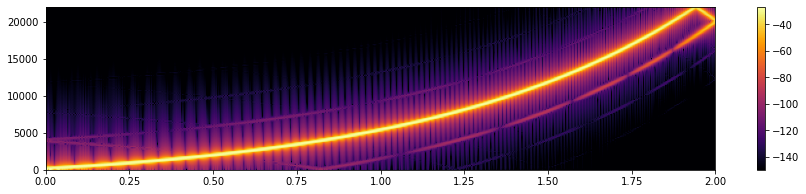

In [11]:
plt.figure(figsize=(15,3))
plt.specgram(torchaudio.transforms.Resample(P, Q)(torch.from_numpy(sig)).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### lilfilter

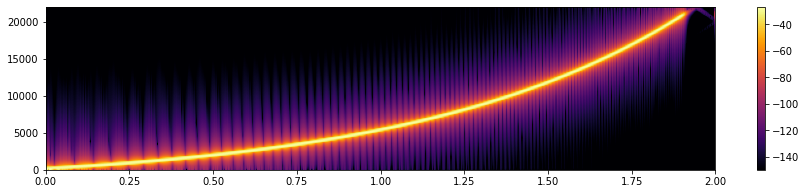

In [12]:
plt.figure(figsize=(15,3))
plt.specgram(lilfilter.resample(sig.reshape([1, -1]), P, Q).reshape([-1]),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### julius

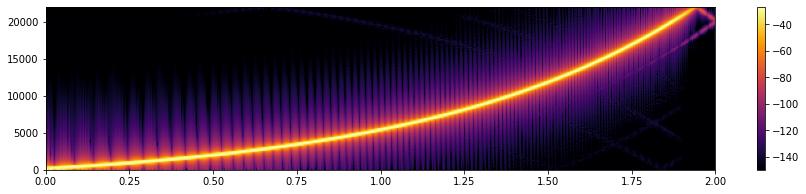

In [13]:
plt.figure(figsize=(15,3))
plt.specgram(julius.resample_frac(torch.from_numpy(sig), P, Q).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

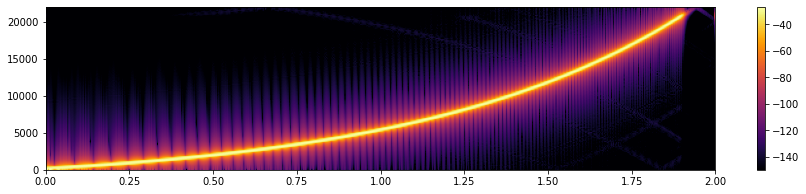

In [14]:
plt.figure(figsize=(15,3))
plt.specgram(julius.resample_frac(torch.from_numpy(sig), P, Q, zeros=150).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

## Upsampling a sweep

In [15]:
P = 48000
Q = 44100
P,Q = Q,P # <== upsampling

offset = 2000
instfreq = np.exp(np.linspace(np.log(offset+100), np.log(offset+23900), 96000))-offset
deltaphase = 2*np.pi*instfreq/P
cphase = np.cumsum(deltaphase)
sig = np.sin(cphase)

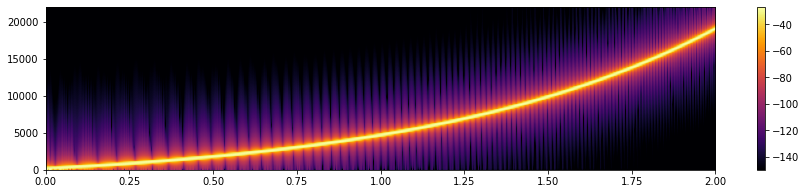

In [16]:
plt.figure(figsize=(15,3))
plt.specgram(sig, scale='dB', Fs=P, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,P/2))

### scikits-resamplerate (libsrc)

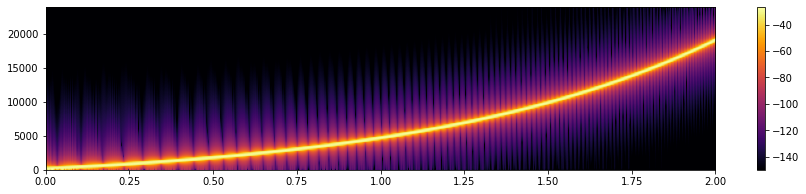

In [17]:
plt.figure(figsize=(15,3))
plt.specgram(scikits.samplerate.resample(sig, Q/P, 'sinc_best'),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### scipy.signal.resample

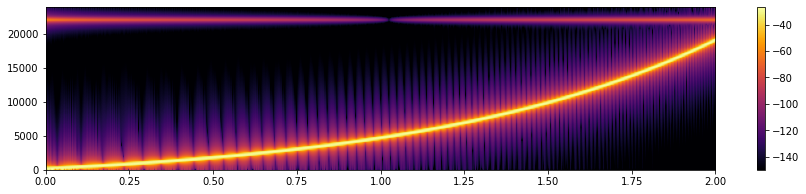

In [18]:
plt.figure(figsize=(15,3))
plt.specgram(scipy.signal.resample(sig, int(len(sig)*Q/P)),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### torchaudio

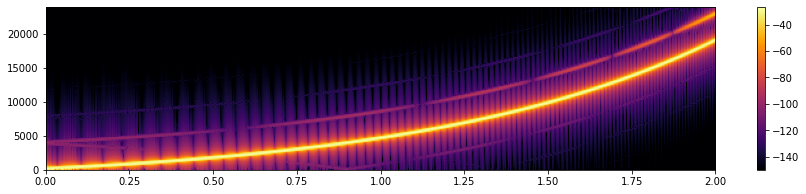

In [19]:
plt.figure(figsize=(15,3))
plt.specgram(torchaudio.transforms.Resample(P, Q)(torch.from_numpy(sig)).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### resampy (librosa)

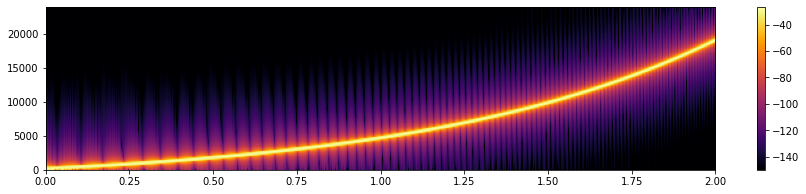

In [20]:
plt.figure(figsize=(15,3))
plt.specgram(resampy.resample(sig, P, Q, filter="kaiser_best"),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

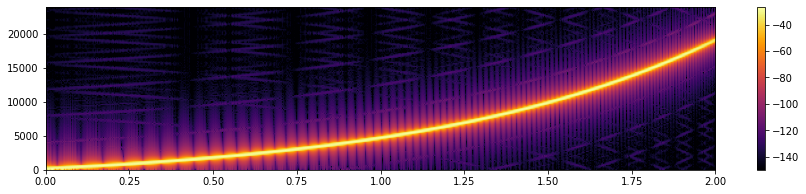

In [21]:
plt.figure(figsize=(15,3))
plt.specgram(resampy.resample(sig, P, Q, filter="kaiser_fast"),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### lilfilter

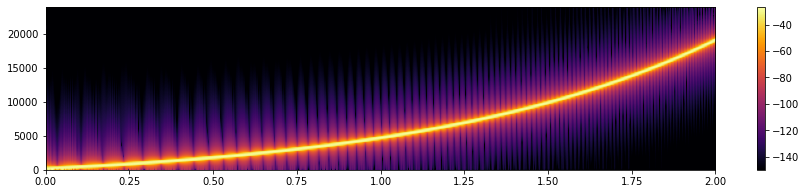

In [22]:
plt.figure(figsize=(15,3))
plt.specgram(lilfilter.resample(sig.reshape([1, -1]), P, Q).reshape([-1]),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### julius

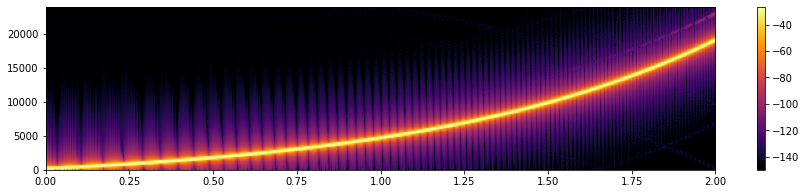

In [23]:
plt.figure(figsize=(15,3))
plt.specgram(julius.resample_frac(torch.from_numpy(sig), P, Q).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

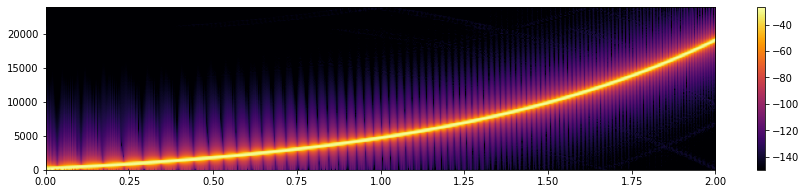

In [24]:
plt.figure(figsize=(15,3))
plt.specgram(julius.resample_frac(torch.from_numpy(sig), P, Q, zeros=150).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

## Upsampling an impulse

A way to examine the antialias filter is to upsample an impulse.  Here, note a frustrating aspect of all these differing libraries: the interface is completely different beween all of them; and to boot, `resampy` and `scikit.resample` give different length outputs for the same upsampling ratio.  This means you can't just switch between them using a `from foo import resample` statement, you'll need a wrapper function if you want to switch freely amongst them (see `librosa` as an example).

In [25]:
P = 48000
Q = 44100

impulse = np.zeros(1000)
impulse[499] = 1

us1 = scikits.samplerate.resample(impulse, P/Q, 'sinc_best')
us11 = samplerate.resample(impulse, P/Q, 'sinc_best')
us2 = scipy.signal.resample(impulse, int(len(impulse)*P/Q))
us3 = resampy.resample(impulse, Q, P, filter="kaiser_best")
us31 = resampy.resample(impulse, Q, P, filter="kaiser_fast")
us4 = torchaudio.transforms.Resample(Q, P)(torch.from_numpy(impulse)).numpy()
us5 = lilfilter.resample(impulse.reshape([1, -1]), Q, P).reshape([-1])
us6 = julius.resample_frac(torch.from_numpy(impulse), Q, P).numpy()

# For some reason, julius + lilfilter results are shifted.
# Align everything to us1
us11 = np.pad(us11, (us1.argmax() - us11.argmax(), 0))
us2 = np.pad(us2, (us1.argmax() - us2.argmax(), 0))
us3 = np.pad(us3, (us1.argmax() - us3.argmax(), 0))
us31 = np.pad(us31, (us1.argmax() - us31.argmax(), 0))
us4 = np.pad(us4, (us1.argmax() - us4.argmax(), 0))
us5 = np.pad(us5, (us1.argmax() - us5.argmax(), 0))
us6 = np.pad(us6, (us1.argmax() - us6.argmax(), 0))

print(us1.shape, us11.shape, us2.shape, us3.shape, us4.shape, us5.shape, us6.shape)

(1087,) (1088,) (1088,) (1088,) (1089,) (960,) (1088,)


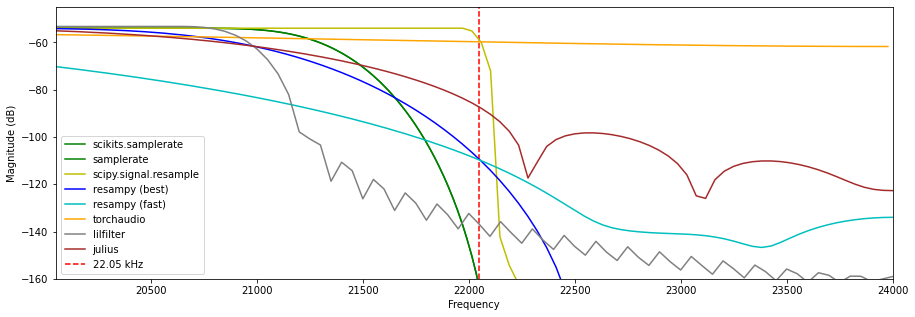

In [26]:
plt.figure(figsize=(15,5))
plt.magnitude_spectrum(us1, c='g', Fs=P, scale='dB', label='scikits.samplerate')
plt.magnitude_spectrum(us11, c='g', Fs=P, scale='dB', label='samplerate')
plt.magnitude_spectrum(us2, c='y', Fs=P, scale='dB', label='scipy.signal.resample')
plt.magnitude_spectrum(us3, c='b', Fs=P, scale='dB', label='resampy (best)')
plt.magnitude_spectrum(us31, c='c', Fs=P, scale='dB', label='resampy (fast)')
plt.magnitude_spectrum(us4, c='orange', Fs=P, scale='dB', label='torchaudio')
plt.magnitude_spectrum(us5, c='grey', Fs=P, scale='dB', label='lilfilter')
plt.magnitude_spectrum(us6, c='brown', Fs=P, scale='dB', label='julius')
plt.axis((Q/2 - 2000, P/2, -160, -45))
_=plt.vlines(Q/2, -160, 3, colors='r', linestyles='dashed', label='22.05 kHz')
_=plt.legend(loc='lower left')

'scikit.resample' certainly uses the best antialias filter, with a steep slope, allowing very little energy over Nyquist.  'resampy' is a more gentle filter (lower order, perhaps?) but decent.  'scipy.signal.resample'... well, anyways.

What do the impulse responses look like in time domain?

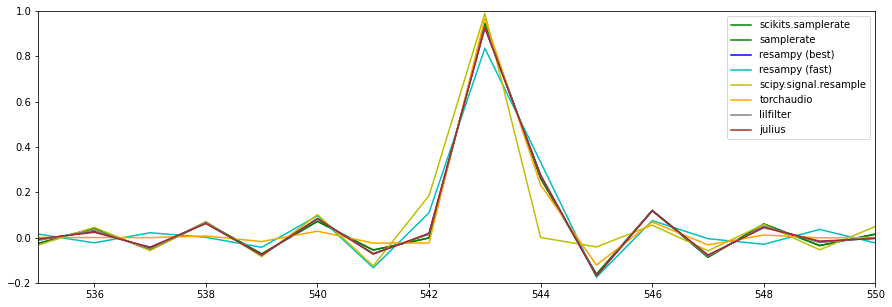

In [27]:
plt.figure(figsize=(15,5))
plt.plot(us1, c='g', label='scikits.samplerate')
plt.plot(us11, c='g', label='samplerate')
plt.plot(us3, c='b', label='resampy (best)')
plt.plot(us31, c='c', label='resampy (fast)')
plt.plot(us2, c='y', label='scipy.signal.resample')
plt.plot(us4, c='orange', label='torchaudio')
plt.plot(us5, c='gray', label='lilfilter')
plt.plot(us6, c='brown', label='julius')
plt.axis((535, 550, -0.2, 1))
_=plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


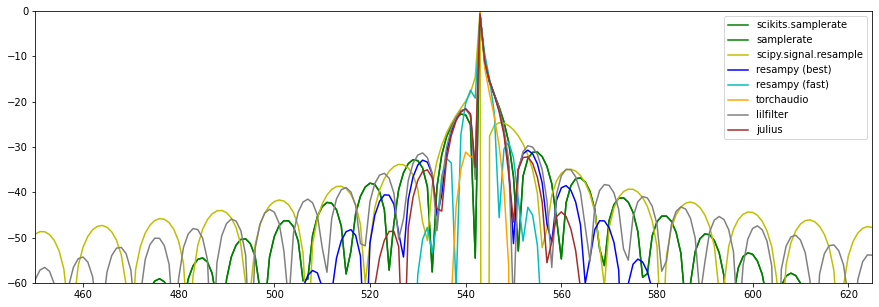

In [28]:
plt.figure(figsize=(15,5))
plt.plot(10*np.log10(np.square(us1)), c='g', label='scikits.samplerate')
plt.plot(10*np.log10(np.square(us11)), c='g', label='samplerate')
plt.plot(10*np.log10(np.square(us2)), c='y', label='scipy.signal.resample')
plt.plot(10*np.log10(np.square(us3)), c='b', label='resampy (best)')
plt.plot(10*np.log10(np.square(us31)), c='c', label='resampy (fast)')
plt.plot(10*np.log10(np.square(us4)), c='orange', label='torchaudio')
plt.plot(10*np.log10(np.square(us5)), c='gray', label='lilfilter')
plt.plot(10*np.log10(np.square(us6)), c='brown', label='julius')
plt.axis((450, 625, -60, 0))
_=plt.legend()

Unsurprisingly, 'resampy' is the most compact, which explains the gentler cut-off.   'scikit.resample' is wider, but acceptable.  'scipy.signal.resample' sticks out like a sore thumb.

## Speed comparison

In [29]:
%timeit scikits.samplerate.resample(sig, Q/P, 'sinc_best')

1 loop, best of 5: 165 ms per loop


In [30]:
%timeit samplerate.resample(sig, Q/P, 'sinc_best')

10 loops, best of 5: 119 ms per loop


In [31]:
%timeit scipy.signal.resample(sig, int(len(sig)*Q/P))

100 loops, best of 5: 3.26 ms per loop


In [32]:
%timeit resampy.resample(sig, P, Q, filter="kaiser_best")
%timeit resampy.resample(sig, P, Q, filter="kaiser_fast")

10 loops, best of 5: 60 ms per loop
100 loops, best of 5: 16 ms per loop


In [33]:
resampler = torchaudio.transforms.Resample(P, Q)
sig_torch = torch.from_numpy(sig)
%timeit resampler(sig_torch) # <== NOTE: ON CPU!

100 loops, best of 5: 13.9 ms per loop


In [37]:
%timeit lilfilter.resample(sig.reshape([1, -1]), P, Q).reshape([-1])#  <== NOTE: ON CPU!

100 loops, best of 5: 9.43 ms per loop


In [36]:
%timeit julius.resample_frac(sig_torch, P, Q) # <== NOTE: ON CPU!
# Should be faster:
%timeit julius.resample_frac(sig_torch, P, 2 * P) # <== NOTE: ON CPU!

100 loops, best of 5: 16.3 ms per loop
100 loops, best of 5: 17.2 ms per loop


And here is a notable merit of 'scipy.signal.resample'.  It is faster by an order of magnitude compared to the other methods.  I suspect that if you make sure your signals are of length $2^N$, you'll get even faster results, since it'll switch to a FFT instead of a DFT.  The other two are probably losing some speed in the passing of data from Python to C - but fundamentally, frequency domain techniques do tend to be fast.  So keep that in mind you you need speed.

## Conclusion

I'll just repeat the above TL;DR: use scikit.resample (0.4.0-dev) if you can install libsamplerate in a sane place. Else, use `resampy`, which is faster, but not as good --- but entirely reasonable.  Use 'scipy.signal.resample' only if you really need the speed, and be aware of its shortcomings (note the circular assumption!).